In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from keras.datasets import mnist

(X_train, y_train),(X_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [3]:
X_train = X_train.astype(float)/255.
X_test = X_test.astype(float)/255.

X_train = X_train.reshape(60000, 28*28)
X_test = X_test.reshape(10000, 28*28)

X_train.shape, X_test.shape

((60000, 784), (10000, 784))

In [4]:
from keras.layers import Input, Dense

input_img = Input(shape=(784,))
encoded = Dense(256, activation='elu')(input_img)
encoded = Dense(128, activation='elu')(encoded)

In [5]:
mean = Dense(2, name='mean')(encoded)
log_var = Dense(2, name='var')(encoded)

In [6]:
from keras import backend as K
from keras.layers import Lambda

def sampling(args):
  mean, log_var = args
  epsilon = K.random_normal(shape =(100,2), mean=0., stddev=1.0)
  return mean + K.exp(log_var) * epsilon

z = Lambda(sampling, output_shape = (2,))([mean, log_var])

In [7]:
from keras.models import Model

encoder = Model(input_img, mean)

encoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 256)               200960    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
mean (Dense)                 (None, 2)                 258       
Total params: 234,114
Trainable params: 234,114
Non-trainable params: 0
_________________________________________________________________


In [8]:
decoder_1 = Dense(128, activation='elu')
decoder_2 = Dense(256, activation='elu')
decoder_3 = Dense(784, activation='sigmoid')

In [9]:
z_sample = decoder_1(z)
z_sample = decoder_2(z_sample)
z_sample = decoder_3(z_sample)
z_sample.shape

TensorShape([100, 784])

In [11]:
decoder_input = Input(shape=(2,))

y_gen = decoder_1(decoder_input)
y_gen = decoder_2(y_gen)
y_gen = decoder_3(y_gen)

In [12]:
generator = Model(decoder_input, y_gen)
generator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_2 (Dense)              multiple                  384       
_________________________________________________________________
dense_3 (Dense)              multiple                  33024     
_________________________________________________________________
dense_4 (Dense)              multiple                  201488    
Total params: 234,896
Trainable params: 234,896
Non-trainable params: 0
_________________________________________________________________


In [13]:
vae = Model(input_img, z_sample)

In [14]:
vae.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          200960      input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          32896       dense[0][0]                      
__________________________________________________________________________________________________
mean (Dense)                    (None, 2)            258         dense_1[0][0]                    
____________________________________________________________________________________________

In [15]:
from keras import objectives

reconstruction_loss = objectives.binary_crossentropy(input_img, z_sample)
kl_loss = 0.0005 * K.mean(K.square(mean) + K.exp(log_var) - log_var -1, axis=-1)

vae_loss = reconstruction_loss + kl_loss

In [16]:
vae.add_loss(vae_loss)

In [17]:
vae.compile(optimizer='Adam')

In [18]:
%%time
vae.fit(X_train, 
        shuffle = True, epochs=300, batch_size=100, validation_data=(X_test, None))

Epoch 1/300
600/600 [==============================] - 4s 3ms/step - loss: 0.2727 - val_loss: 0.2179
Epoch 2/300
600/600 [==============================] - 1s 2ms/step - loss: 0.2150 - val_loss: 0.2072
Epoch 3/300
600/600 [==============================] - 1s 2ms/step - loss: 0.2057 - val_loss: 0.2007
Epoch 4/300
600/600 [==============================] - 1s 2ms/step - loss: 0.1989 - val_loss: 0.1949
Epoch 5/300
600/600 [==============================] - 1s 2ms/step - loss: 0.1937 - val_loss: 0.1908
Epoch 6/300
600/600 [==============================] - 1s 2ms/step - loss: 0.1902 - val_loss: 0.1887
Epoch 7/300
600/600 [==============================] - 1s 2ms/step - loss: 0.1883 - val_loss: 0.1872
Epoch 8/300
600/600 [==============================] - 1s 2ms/step - loss: 0.1861 - val_loss: 0.1855
Epoch 9/300
600/600 [==============================] - 1s 2ms/step - loss: 0.1854 - val_loss: 0.1845
Epoch 10/300
600/600 [==============================] - 1s 2ms/step - loss: 0.1834 - val_lo

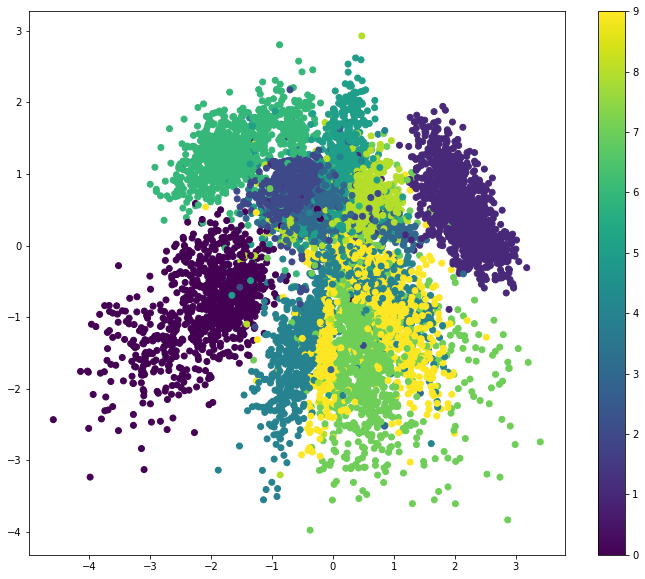

In [19]:
X_test_latent = encoder.predict(X_test, batch_size=100)

plt.figure(figsize=(12,10))
plt.scatter(X_test_latent[:,0], X_test_latent[:,1], c=y_test)
plt.colorbar()
plt.show()

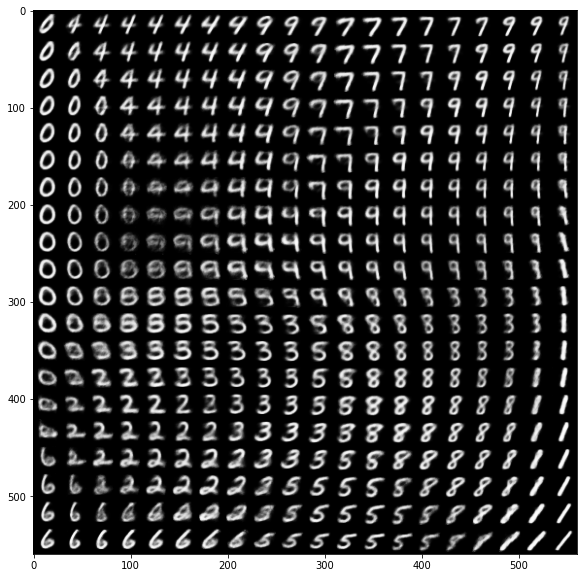

In [20]:
from scipy.stats import norm

n = 20
digit_size=28
figure = np.zeros((digit_size*n, digit_size*n))

grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
  for j, xi in enumerate(grid_y):
    z_sample= np.array([[xi, yi]])
    x_decoded = generator.predict(z_sample)
    digit = x_decoded[0].reshape(digit_size, digit_size)
    figure[i*digit_size:(i+1) * digit_size,
           j * digit_size : (j + 1)* digit_size] = digit

plt.figure(figsize=(10,10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

In [21]:
encoded_latent = encoder.predict(X_test)
encoded_latent.shape

(10000, 2)

In [22]:
generated_imgs = generator.predict(encoded_latent)
generated_imgs.shape

(10000, 784)

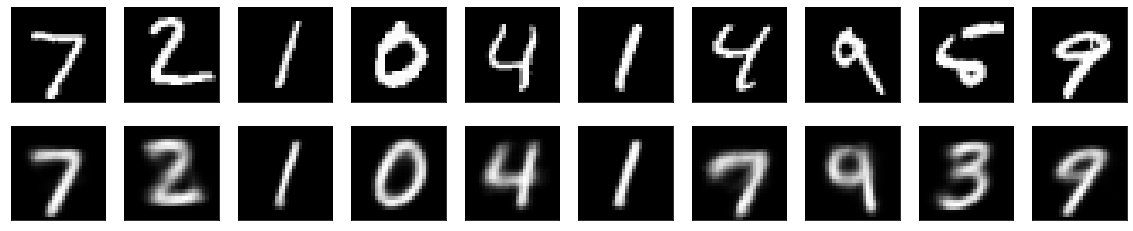

In [23]:
n =10
plt.figure(figsize = (20, 4))

for i in range(n):
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(X_test[i].reshape(28, 28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(generated_imgs[i].reshape(28, 28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()